In [154]:
import warnings
warnings.filterwarnings('ignore')

In [153]:
# Essential Libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import pandas_profiling as ppf
import calendar


In [2]:
# Modelling libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import PCA # Principal Component analusis (Variable Reduction)
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# Data Preparation

In [3]:
customer_data = pd.read_excel("Data/CustomersData.xlsx")
online_sales = pd.read_csv("Data/Online_Sales.csv")
marketing_spend = pd.read_csv("Data/Marketing_Spend.csv")
disc_coupon = pd.read_csv("Data/Discount_Coupon.csv")
tax_amount = pd.read_excel("Data/Tax_amount.xlsx")

### Lets see the data

In [4]:
customer_data.head()

,CustomerID,Gender,Location,Tenure_Months
0,17850,M,Chicago,12
1,13047,M,California,43
2,12583,M,Chicago,33
3,13748,F,California,30
4,15100,M,California,49


In [5]:
online_sales.head()

,CustomerID,Transaction_ID,Transaction_Date,Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status
0,17850,16679,20190101,1/1/2019,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used
1,17850,16680,20190101,1/1/2019,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used
2,17850,16681,20190101,1/1/2019,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.5,Used
3,17850,16682,20190101,1/1/2019,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,5,17.53,6.5,Not Used
4,17850,16682,20190101,1/1/2019,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.50,6.5,Used


In [6]:
online_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52924 entries, 0 to 52923
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CustomerID           52924 non-null  int64  
 1   Transaction_ID       52924 non-null  int64  
 2   Transaction_Date     52924 non-null  int64  
 3   Date                 52924 non-null  object 
 4   Product_SKU          52924 non-null  object 
 5   Product_Description  52924 non-null  object 
 6   Product_Category     52924 non-null  object 
 7   Quantity             52924 non-null  int64  
 8   Avg_Price            52924 non-null  float64
 9   Delivery_Charges     52924 non-null  float64
 10  Coupon_Status        52924 non-null  object 
dtypes: float64(2), int64(4), object(5)
memory usage: 4.4+ MB


In [7]:
## Changing the dtype of the date column
online_sales["Date"] = pd.to_datetime(online_sales["Date"])

In [8]:
marketing_spend.head()

,Date,Offline_Spend,Online_Spend
0,1/1/2019,4500,2424.50
1,1/2/2019,4500,3480.36
2,1/3/2019,4500,1576.38
3,1/4/2019,4500,2928.55
4,1/5/2019,4500,4055.30


In [9]:
marketing_spend.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           365 non-null    object 
 1   Offline_Spend  365 non-null    int64  
 2   Online_Spend   365 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 8.7+ KB


In [10]:
# Lets make Some new variables
marketing_spend["Date"] = pd.to_datetime(marketing_spend["Date"])
marketing_spend["Month"] = marketing_spend["Date"].dt.month.apply(lambda x:calendar.month_abbr[x])
marketing_spend["Total_Spend"] = marketing_spend.Offline_Spend+ marketing_spend.Online_Spend

In [11]:

disc_coupon.head()

,Month,Product_Category,Coupon_Code,Discount_pct
0,Jan,Apparel,SALE10,10
1,Feb,Apparel,SALE20,20
2,Mar,Apparel,SALE30,30
3,Jan,Nest-USA,ELEC10,10
4,Feb,Nest-USA,ELEC20,20


In [12]:
tax_amount.head()

,Product_Category,GST
0,Nest-USA,0.10
1,Office,0.10
2,Apparel,0.18
3,Bags,0.18
4,Drinkware,0.18


In [13]:
# Lets make dates a datetime variable
marketing_spend["Date"] = pd.to_datetime(marketing_spend["Date"])
marketing_spend["Month"] = marketing_spend["Date"].dt.month.apply(lambda x:calendar.month_abbr[x])
marketing_spend["Total_Spend"] = marketing_spend.Offline_Spend+ marketing_spend.Online_Spend

# Data Preparation

In [14]:
# Joining the online_sales and customer_data
sales_customer = pd.merge(online_sales,customer_data,on="CustomerID",how="inner").sort_values(by=["CustomerID","Date"])

In [15]:

sales_customer = sales_customer[['CustomerID','Gender', 'Location',
       'Tenure_Months', 'Transaction_ID', 'Transaction_Date',"Date",
       'Product_SKU', 'Product_Description', 'Product_Category', 'Quantity',
       'Avg_Price', 'Delivery_Charges', 'Coupon_Status']]

In [16]:
sales_customer = sales_customer.drop("Transaction_Date",axis=1)

In [17]:
import calendar
sales_customer["Month"]=sales_customer.Date.dt.month.apply(lambda x:calendar.month_abbr[x])

In [18]:
# There is a space Product_Category column name
disc_coupon.columns = ['Month', 'Product_Category', 'Coupon_Code', 'Discount_pct']

In [19]:
## Adding cupon information in that particular month
sales_customer = pd.merge(sales_customer,disc_coupon,on=["Month","Product_Category"],how="left")

In [20]:
## Adding tax information
sales_customer = pd.merge(sales_customer,tax_amount,on="Product_Category",how="left")

In [21]:
sales_customer.Discount_pct = sales_customer.Discount_pct/100

In [22]:
sales_customer.isna().sum()

CustomerID               0
Gender                   0
Location                 0
Tenure_Months            0
Transaction_ID           0
Date                     0
Product_SKU              0
Product_Description      0
Product_Category         0
Quantity                 0
Avg_Price                0
Delivery_Charges         0
Coupon_Status            0
Month                    0
Coupon_Code            400
Discount_pct           400
GST                      0
dtype: int64

In [23]:
# First lets fill nan with 0 to make calculations possible
# Where there is no discount is given 
sales_customer.fillna(0,inplace=True)

In [24]:
# We can encode coupon status to be 0 for not used and clicked and 1 for used 
# It will also make calculations easy 
# just multiply with the coupon status encoded column to add or not add the discount percentage

In [25]:

sales_customer["Invoice_Value"] = (sales_customer.Quantity*sales_customer.Avg_Price)*(1-sales_customer.Discount_pct*sales_customer.Coupon_Status.replace(['Used', 'Clicked','Not Used'],[1,0,0]))*(1+sales_customer.GST)+sales_customer.Delivery_Charges

In [26]:
sales_customer.to_csv("Summaries/Final_DF.csv")

_____

# EDA

In [27]:
df_eda = sales_customer.copy()

## Understanding how many customers acquired every month

In [28]:
cust_each_month = df_eda[~df_eda.CustomerID.duplicated()].groupby("Month")["CustomerID"].count().reindex(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]).reset_index()

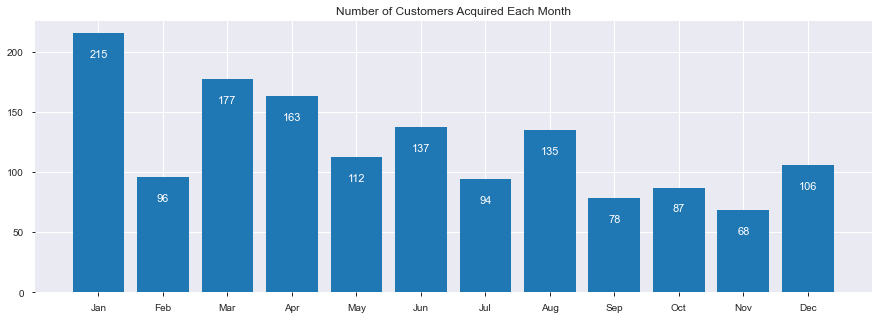

In [29]:
cust_each_month.columns = ["Month","Customers_Acquired"]
plt.figure(figsize = (15,5))
bars = plt.bar(cust_each_month.Month,cust_each_month.Customers_Acquired)
plt.title("Number of Customers Acquired Each Month")
for bar in bars:
    plt.gca().text(bar.get_x() + bar.get_width()/2, bar.get_height() - 20, str(int(bar.get_height())), 
                 ha='center', color='w', fontsize=11)


## Understanding the retention of customers on month on month basis

In [30]:
# Total customers in each month 
cust_each_month["At_end"] = df_eda.groupby("Month")["CustomerID"].nunique().reindex(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]).values
cust_each_month["In_Beginning"] = cust_each_month.At_end.shift(1).fillna(0)
cust_each_month["Retention"] = ((cust_each_month.At_end - cust_each_month.Customers_Acquired)/cust_each_month.In_Beginning)*100
cust_each_month = cust_each_month.fillna(0)

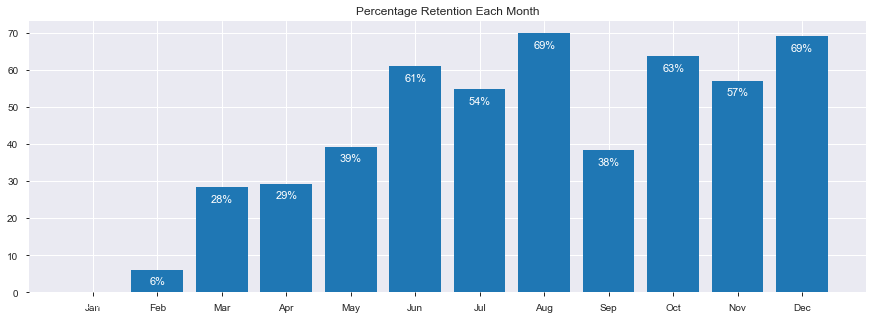

In [31]:
plt.figure(figsize = (15,5))
bars = plt.bar(cust_each_month.Month,cust_each_month.Retention)
plt.title("Percentage Retention Each Month")
for bar in bars:
    plt.gca().text(bar.get_x() + bar.get_width()/2, bar.get_height() - 4, str(int(bar.get_height()))+"%", 
                 ha='center', color='w', fontsize=11)


## How the revenues from existing/new customers on month on month basis

In [32]:
# ALL THE CUSTOMERS THAT ARE NEW IN ANY MONTH
df_new = df_eda[~df_eda.CustomerID.duplicated()].groupby("Month")[["CustomerID","Invoice_Value"]].agg({"CustomerID":"count","Invoice_Value":sum}).reindex(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]).reset_index()
# ALL THE CUSTOMERS THAT ARE ALREADY CUSTOMERS
df_existing = df_eda[df_eda.CustomerID.duplicated()].groupby("Month")[["CustomerID","Invoice_Value"]].agg({"CustomerID":"count","Invoice_Value":sum}).reindex(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]).reset_index()

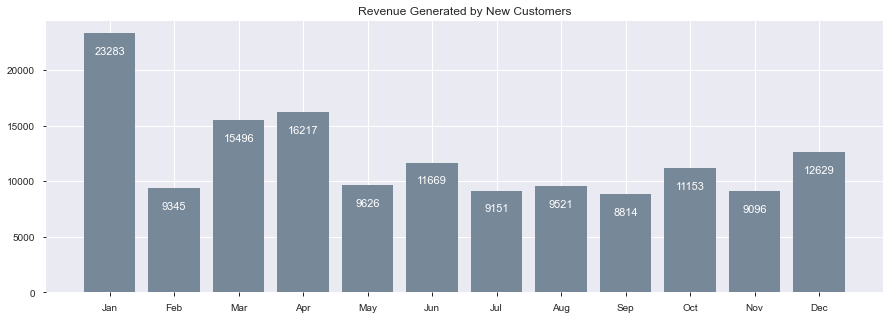

Text(0.5, 1.0, 'Revenue Generated by New Customers')

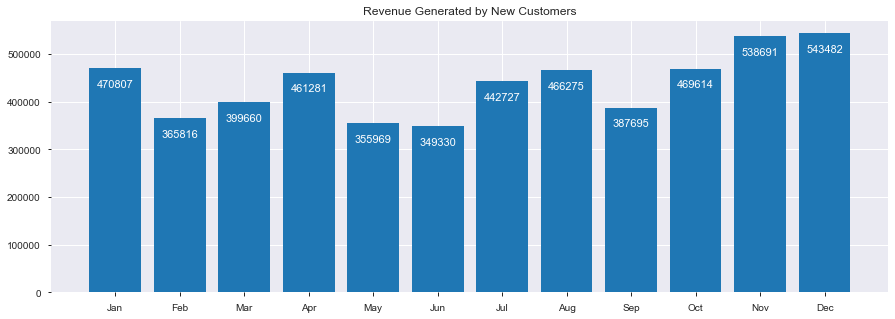

In [33]:
plt.figure(figsize = (15,5))
bars = plt.bar(df_new.Month,df_new.Invoice_Value,color='lightslategrey')
plt.title("Revenue Generated by New Customers")
for bar in bars:
    plt.gca().text(bar.get_x() + bar.get_width()/2, bar.get_height() - 1900, str(int(bar.get_height())), 
                 ha='center', color='w', fontsize=11)
plt.show()

plt.figure(figsize=(15,5))
bars = plt.bar(df_new.Month,df_existing.Invoice_Value)
for bar in bars:
    plt.gca().text(bar.get_x() + bar.get_width()/2, bar.get_height() - 40000, str(int(bar.get_height())), 
                 ha='center', color='w', fontsize=11)
plt.title("Revenue Generated by New Customers")

## Analyse KPI’s like Revenue, number of orders, average order value, number of customers (existing/new), quantity, by category, by month, by week, by day etc…

### By Category

In [34]:
# By product Category
df_category = df_eda.groupby("Product_Category").agg({"Invoice_Value":"sum","Transaction_ID":"count"}).round().reset_index()
df_category["Average Order Value"] = df_category.Invoice_Value/df_category.Transaction_ID
df_category.columns = ['Product_Category', 'Invoice_Value', 'Transaction_ID(Count)',
       'Average Order Value']

In [35]:
df_category

,Product_Category,Invoice_Value,Transaction_ID(Count),Average Order Value
0,Accessories,10199.0,234,43.585470
1,Android,1116.0,43,25.953488
2,Apparel,827829.0,18126,45.670804
3,Backpacks,10813.0,89,121.494382
4,Bags,193627.0,1882,102.883634
5,Bottles,10172.0,268,37.955224
6,Drinkware,272622.0,3483,78.272179
7,Fun,8995.0,160,56.218750
8,Gift Cards,19447.0,159,122.308176
9,Google,13169.0,105,125.419048


### By Month

In [36]:
df_month = df_eda.groupby("Month").agg({"Invoice_Value":"sum","Transaction_ID":"count"}).round().reindex(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
df_month["Average Order Value"] = df_month.Invoice_Value/df_month.Transaction_ID
df_month.columns = ['Invoice_Value', 'Transaction_ID(Count)',
       'Average Order Value']

df_month.reset_index()

,Month,Invoice_Value,Transaction_ID(Count),Average Order Value
0,Jan,494091.0,4063,121.607433
1,Feb,375162.0,3284,114.239342
2,Mar,415158.0,4346,95.526461
3,Apr,477499.0,4150,115.060000
4,May,365596.0,4572,79.964129
5,Jun,361000.0,4193,86.095874
6,Jul,451878.0,5251,86.055608
7,Aug,475797.0,6150,77.365366
8,Sep,396510.0,4288,92.469683
9,Oct,480767.0,4164,115.457973


### By Week

In [37]:
sales_customer["Date"] = pd.to_datetime(sales_customer["Date"])
sales_customer["Week"] = sales_customer.Date.dt.isocalendar().week
df_week = sales_customer.groupby("Week").agg({"Invoice_Value":"sum","Transaction_ID":"count"})
df_week["Average Order Value"] = df_week.Invoice_Value/df_week.Transaction_ID
df_week.columns = ['Invoice_Value', 'Transaction_ID(Count)',
       'Average Order Value']
df_week.reset_index()

,Week,Invoice_Value,Transaction_ID(Count),Average Order Value
0,1,131077.87837,1056,124.126779
1,2,104569.21104,829,126.138976
2,3,106868.31322,842,126.921987
3,4,109560.62304,943,116.183057
4,5,105695.03401,926,114.141505
5,6,89697.85810,749,119.756820
6,7,101107.17060,881,114.764098
7,8,98127.24106,876,112.017398
8,9,83657.95910,810,103.281431
9,10,92773.01870,1012,91.672943


## Understand the trends/seasonality of sales by category, location, month etc…

Text(0.5, 1.0, 'Sales for different locations')

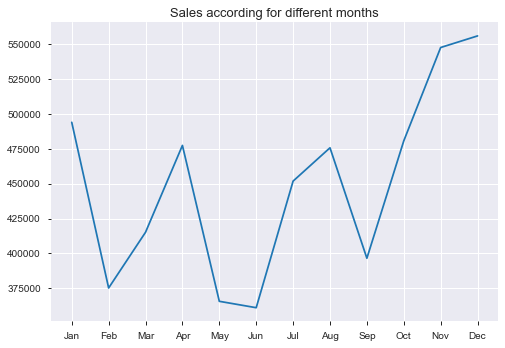

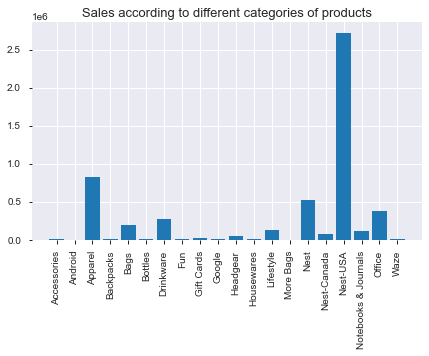

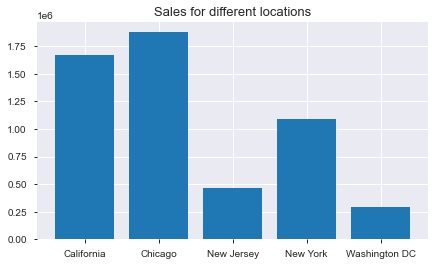

In [38]:
month = df_eda.groupby("Month")["Invoice_Value"].sum().reindex(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]).reset_index()
category = df_eda.groupby("Product_Category")["Invoice_Value"].sum().reset_index()
plt.plot(month.Month,month.Invoice_Value)
plt.title("Sales according for different months",size=13)

plt.figure(figsize=(7,4))
plt.bar(category.Product_Category,category.Invoice_Value)
xaxis = plt.gca().xaxis
for item in xaxis.get_ticklabels():
    # we can use artist methods or function on these tick labels
    item.set_rotation(90)
plt.title("Sales according to different categories of products",size=13)    


location = df_eda.groupby("Location")["Invoice_Value"].sum().reset_index()
plt.figure(figsize=(7,4))
plt.bar(location.Location,location.Invoice_Value)
plt.title("Sales for different locations",size=13)

## How number order varies and sales with different days?

Text(0.5, 1.0, 'Number of orders placed on each day')

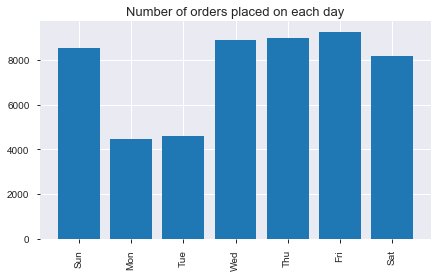

In [39]:
import calendar
df_eda["Day"] = df_eda.Date.dt.weekday.apply(lambda x: calendar.day_abbr[x])

orders = df_eda.groupby("Day")["Transaction_ID"].count().reindex(["Sun","Mon","Tue","Wed","Thu","Fri","Sat"]).reset_index()
plt.figure(figsize=(7,4))
plt.bar(orders.Day,orders.Transaction_ID)
xaxis = plt.gca().xaxis
for item in xaxis.get_ticklabels():
    # we can use artist methods or function on these tick labels
    item.set_rotation(90)
plt.title("Number of orders placed on each day",size=13) 

Text(0.5, 1.0, 'Total Sale on each day')

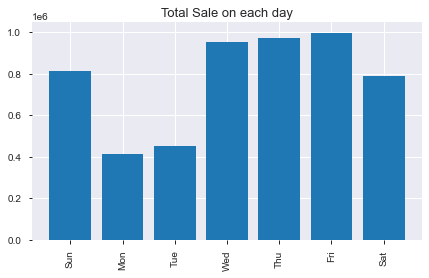

In [40]:
sales = df_eda.groupby("Day")["Invoice_Value"].sum().reindex(["Sun","Mon","Tue","Wed","Thu","Fri","Sat"]).reset_index()
plt.figure(figsize=(7,4))
plt.bar(sales.Day,sales.Invoice_Value)
xaxis = plt.gca().xaxis
for item in xaxis.get_ticklabels():
    # we can use artist methods or function on these tick labels
    item.set_rotation(90)
plt.title("Total Sale on each day",size=13) 

## Calculate the Revenue, Marketing spend, percentage of marketing spend out of revenue, Tax, percentage of delivery charges by month.

#### % of Marketing Spend

In [41]:
marketing_spend = pd.read_csv("Data/Marketing_Spend.csv")

In [42]:
marketing_spend["Date"] = pd.to_datetime(marketing_spend["Date"])
marketing_spend["Month"] = marketing_spend["Date"].dt.month.apply(lambda x:calendar.month_abbr[x])
marketing_spend["Total_Spend"] = marketing_spend.Offline_Spend+ marketing_spend.Online_Spend

In [43]:
Revenue = df_eda.groupby("Month")["Invoice_Value"].sum().reindex(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]).reset_index()
ms = marketing_spend.groupby("Month")["Total_Spend"].sum().reindex(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]).reset_index()

In [44]:
data = pd.merge(Revenue,ms,on="Month",how="outer")
data.columns = ["Month","Revenue","Marketing_Spend"]

data["Pct_Spend"] = (data.Marketing_Spend/data.Revenue)*100

data

,Month,Revenue,Marketing_Spend,Pct_Spend
0,Jan,494090.54875,154928.95,31.356388
1,Feb,375162.04730,137107.92,36.546319
2,Mar,415157.79044,122250.09,29.446657
3,Apr,477498.59102,157026.83,32.885297
4,May,365596.02956,118259.64,32.347080
5,Jun,361000.17429,134318.14,37.207223
6,Jul,451878.40904,120217.85,26.604026
7,Aug,475796.87554,142904.15,30.034697
8,Sep,396510.49254,135514.54,34.176785
9,Oct,480767.36981,151224.65,31.454849


#### % of delivery charges by month

In [45]:
dlvry = df_eda.groupby("Month")[["Delivery_Charges","Invoice_Value"]].sum().reindex(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]).reset_index()
dlvry["Pct_Delivery_Charge"]=dlvry.Delivery_Charges/dlvry.Invoice_Value*100
dlvry

,Month,Delivery_Charges,Invoice_Value,Pct_Delivery_Charge
0,Jan,59242.32,494090.54875,11.990175
1,Feb,49216.60,375162.04730,13.118758
2,Mar,60799.94,415157.79044,14.645020
3,Apr,41481.74,477498.59102,8.687301
4,May,41396.17,365596.02956,11.322927
5,Jun,37513.58,361000.17429,10.391568
6,Jul,48723.93,451878.40904,10.782531
7,Aug,61099.57,475796.87554,12.841524
8,Sep,41005.42,396510.49254,10.341572
9,Oct,45961.88,480767.36981,9.560108


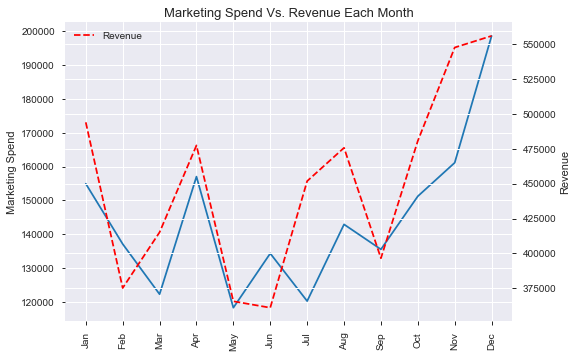

In [46]:
data
fig, ax = plt.subplots()
ax.plot(data.Month,data.Marketing_Spend,label="Marketing Spend")
xaxis = plt.gca().xaxis
for item in xaxis.get_ticklabels():
    # we can use artist methods or function on these tick labels
    item.set_rotation(90)
ax.set_ylabel("Marketing Spend")
    
ax2 = ax.twinx()
ax2.plot(data.Month,data.Revenue,"--r",label="Revenue")
ax2.set_ylabel("Revenue")
# plt.plot(data.Month,data.Revenue)
plt.title("Marketing Spend Vs. Revenue Each Month",size=13) 
plt.legend()

### Which product was appeared in the transactions

In [47]:
df_eda.groupby("Product_Description")["Transaction_ID"].count().idxmax()

'Nest Learning Thermostat 3rd Gen-USA - Stainless Steel'

###  Which product was purchased mostly based on the quantity?

In [48]:
df_eda.groupby("Product_Description")["Quantity"].sum().idxmax()

'Maze Pen'

_________

# Cohort Analysis

In [49]:
cohort_df = sales_customer.copy()

In [50]:
cohort_df["Cohort_Date"] = cohort_df.groupby("CustomerID")["Date"].transform(min)

In [51]:

cohort_df["Cohort_Month"] = cohort_df["Cohort_Date"].dt.month

In [52]:
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    date = df[column].dt.date
    return year, month, date

Invoice_Year, Invoice_Month, _ = get_date_int(cohort_df, 'Date')
Cohort_Year, Cohort_Month , _ = get_date_int(cohort_df, 'Cohort_Date')

Year_Diff = Invoice_Year - Cohort_Year
Month_Diff = Invoice_Month - Cohort_Month

cohort_df['Cohort_Index'] = Year_Diff*12 + Month_Diff +1

In [53]:
cohort_df.groupby("Cohort_Month").count()

,CustomerID,Gender,Location,Tenure_Months,Transaction_ID,Date,Product_SKU,Product_Description,Product_Category,Quantity,...,Delivery_Charges,Coupon_Status,Month,Coupon_Code,Discount_pct,GST,Invoice_Value,Week,Cohort_Date,Cohort_Index
Cohort_Month,,,,,,,,,,,,,,,,,,,,,
1,10938,10938,10938,10938,10938,10938,10938,10938,10938,10938,...,10938,10938,10938,10938,10938,10938,10938,10938,10938,10938
2,6214,6214,6214,6214,6214,6214,6214,6214,6214,6214,...,6214,6214,6214,6214,6214,6214,6214,6214,6214,6214
3,7669,7669,7669,7669,7669,7669,7669,7669,7669,7669,...,7669,7669,7669,7669,7669,7669,7669,7669,7669,7669
4,5015,5015,5015,5015,5015,5015,5015,5015,5015,5015,...,5015,5015,5015,5015,5015,5015,5015,5015,5015,5015
5,4539,4539,4539,4539,4539,4539,4539,4539,4539,4539,...,4539,4539,4539,4539,4539,4539,4539,4539,4539,4539
6,3754,3754,3754,3754,3754,3754,3754,3754,3754,3754,...,3754,3754,3754,3754,3754,3754,3754,3754,3754,3754
7,2984,2984,2984,2984,2984,2984,2984,2984,2984,2984,...,2984,2984,2984,2984,2984,2984,2984,2984,2984,2984
8,3691,3691,3691,3691,3691,3691,3691,3691,3691,3691,...,3691,3691,3691,3691,3691,3691,3691,3691,3691,3691
9,1893,1893,1893,1893,1893,1893,1893,1893,1893,1893,...,1893,1893,1893,1893,1893,1893,1893,1893,1893,1893


In [54]:
cohort_monthwise = cohort_df.pivot_table(values="CustomerID",index="Cohort_Month",columns="Cohort_Index",aggfunc=pd.Series.nunique)

In [55]:
cohort_monthwise.iloc[0]/cohort_monthwise.iloc[0].sum()

Cohort_Index
1     0.398148
2     0.024074
3     0.044444
4     0.062963
5     0.042593
6     0.081481
7     0.064815
8     0.087037
9     0.042593
10    0.051852
11    0.037037
12    0.062963
Name: 1, dtype: float64

In [56]:
cohort_monthwise["Total"] = pd.Series()

<ipython-input-56-fb70fb3287be>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cohort_monthwise["Total"] = pd.Series()


In [57]:
for i in range(12):
    cohort_monthwise["Total"].iloc[i]= cohort_monthwise.iloc[i].sum()

In [58]:
cohort_monthwise

Cohort_Index,1,2,3,4,5,6,7,8,9,10,11,12,Total
Cohort_Month,,,,,,,,,,,,,
1,215.0,13.0,24.0,34.0,23.0,44.0,35.0,47.0,23.0,28.0,20.0,34.0,540.0
2,96.0,7.0,9.0,16.0,17.0,22.0,19.0,15.0,12.0,11.0,16.0,NaN,240.0
3,177.0,18.0,35.0,25.0,32.0,33.0,22.0,22.0,15.0,19.0,NaN,NaN,398.0
4,163.0,14.0,24.0,24.0,18.0,15.0,10.0,16.0,12.0,NaN,NaN,NaN,296.0
5,112.0,12.0,9.0,13.0,10.0,13.0,14.0,8.0,NaN,NaN,NaN,NaN,191.0
6,137.0,20.0,22.0,12.0,11.0,14.0,11.0,NaN,NaN,NaN,NaN,NaN,227.0
7,94.0,13.0,4.0,6.0,11.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,137.0
8,135.0,14.0,15.0,10.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,182.0
9,78.0,6.0,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.0


In [59]:
cohort_monthwise = cohort_monthwise.fillna(0)

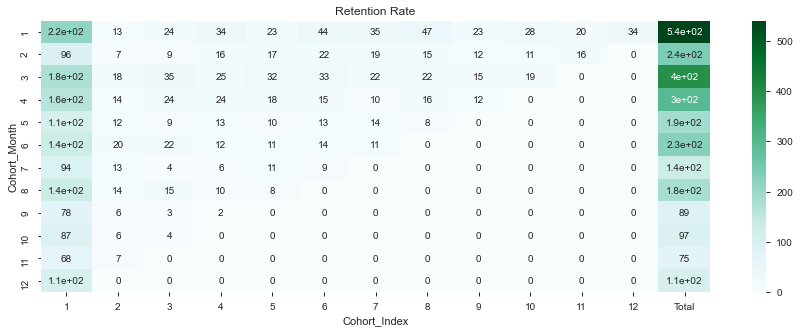

In [60]:
plt.figure(figsize=(15,5))
plt.title("Retention Rate")
sns.heatmap(data=cohort_monthwise,
           annot=True,
           cmap="BuGn"
           )
plt.show()

______________

# Segmentation

----------

## RFM

In [61]:
final_df = sales_customer.copy()

In [62]:
monetary = final_df.groupby("CustomerID")["Invoice_Value"].sum()

In [63]:
frequency = final_df.CustomerID.value_counts()

In [64]:
# For Recency we can use the last transection date 
date_last_trans = final_df.groupby("CustomerID")["Date"].max()

In [65]:
# I've Choosed the date from which to countthe days of last transsaction to be 31/12/2019
recency = pd.datetime(2019,12,31)-date_last_trans

<ipython-input-65-4534013c75b3>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  recency = pd.datetime(2019,12,31)-date_last_trans


In [66]:
CustomerID = monetary.index

In [67]:
# Lets make the dataframe
rfm_df = pd.DataFrame([CustomerID,recency,frequency,monetary]).T

In [68]:
rfm_df.columns = ["CustomerID","Recency","Frequency","Monetary"]

In [69]:
rfm_df.Frequency = rfm_df.Frequency.astype("int")
rfm_df.Monetary = rfm_df.Monetary.astype("int")
rfm_df.Recency = rfm_df.Recency.dt.days

In [70]:
rfm_df.quantile([.33,.67])

,Recency,Frequency,Monetary
0.33,78.00,13.0,1089.22
0.67,187.89,35.0,3489.56


## RFM Analysis

In [71]:
rfm_df["r_seg"] = np.where(rfm_df.Recency<=78,"Active",np.where(rfm_df.Recency<=187.9,"At Risk","Churn"))

In [72]:
rfm_df["f_seg"] = np.where(rfm_df.Frequency<=13,1,np.where(rfm_df.Frequency<=35,2,3))

In [73]:
rfm_df["m_seg"] = np.where(rfm_df.Monetary<=940.11,1,np.where(rfm_df.Monetary<=3034.78,2,3))

In [74]:
# Lets also make the fm_seg 
rfm_df["fm_seg"] = np.where((rfm_df.f_seg==3)&(rfm_df.m_seg==3),"Platinum",
                            np.where(((rfm_df.f_seg==3)&(rfm_df.m_seg==2))|((rfm_df.f_seg==2)&(rfm_df.m_seg==3)),"Gold",
                            np.where(((rfm_df.f_seg==2)&(rfm_df.m_seg==2))|((rfm_df.f_seg==1)&(rfm_df.m_seg==3))|((rfm_df.f_seg==3)&(rfm_df.m_seg==1)),"Silver","Standard")))

In [75]:
final_df.groupby("CustomerID").sum().reset_index()

,CustomerID,Tenure_Months,Transaction_ID,Quantity,Avg_Price,Delivery_Charges,Discount_pct,GST,Invoice_Value,Week
0,12346,62,76446,3,25.49,150.00,0.6,0.28,174.98174,74
1,12347,1200,1972760,342,3746.16,665.14,14.8,7.77,15686.84396,1648
2,12348,897,774484,209,336.52,197.15,5.7,3.42,1689.55594,677
3,12350,425,796889,21,1312.40,127.88,5.1,2.16,1467.43528,850
4,12356,1116,1375803,56,1244.83,637.49,10.8,5.34,2007.42900,1332
...,...,...,...,...,...,...,...,...,...,...
1463,18259,35,174149,46,84.73,278.33,0.6,1.13,860.68600,98
1464,18260,1720,1379321,141,1114.89,632.42,8.6,5.41,3016.54372,1227
1465,18269,200,204995,10,89.34,51.50,1.0,1.36,166.90750,123
1466,18277,47,41388,2,149.00,6.00,0.1,0.10,333.80000,43


In [76]:
profiling = pd.merge(final_df.groupby("CustomerID").sum().reset_index(),rfm_df,on="CustomerID")

In [77]:
profiling_output = profiling[["Avg_Price","Delivery_Charges","Discount_pct","GST","Invoice_Value","Recency","Frequency","Monetary","r_seg","fm_seg"]].groupby(["r_seg","fm_seg"]).mean().T

In [78]:
profiling_output.to_csv("Summaries/rfm_segmentation.csv")

In [79]:
profiling_output

r_seg                  Active                                         \
fm_seg                   Gold     Platinum       Silver     Standard   
Avg_Price         3544.035606  4293.554021  2892.282532   688.278738   
Delivery_Charges   675.965758   757.814742   458.165844   106.572621   
Discount_pct        12.210606    14.349485    10.088961     2.884466   
GST                  8.189318     9.220000     6.237662     1.749612   
Invoice_Value     6982.103922  8192.953024  5069.345065  1165.491055   
Recency             37.106061    33.525773    35.779221    34.533981   
Frequency           53.106061    81.288660    22.844156    12.000000   
Monetary          6981.606061  8192.422680  5068.805195  1164.961165   

r_seg                 At Risk                                        \
fm_seg                   Gold     Platinum       Silver    Standard   
Avg_Price         2218.936396  3327.856250  1552.262022  518.008231   
Delivery_Charges   500.490450   759.998750   317.876721  109.110136   
Discount_pct         9.856757    12.564286     6.678689    2.514966   
GST                  7.112703    10.187143     4.830000    1.847823   
Invoice_Value     4531.180565  7538.810118  2928.215077  916.946758   
Recency            130.693694   121.785714   130.666667  133.931973   
Frequency           58.162162    73.803571    43.994536   11.727891   
Monetary          4530.711712  7538.357143  2927.715847  916.489796   

r_seg                   Churn                                        
fm_seg                   Gold     Platinum       Silver    Standard  
Avg_Price         1921.422353  2494.145500  1412.410542  461.077919  
Delivery_Charges   445.844706   673.985500   347.991446  118.363401  
Discount_pct         7.075490    10.195000     5.351205    2.143147  
GST                  5.201078     7.090500     3.996386    1.561726  
Invoice_Value     4108.154915  5832.271868  2853.690796  888.837634  
Recency            274.333333   261.550000   266.644578  264.979695  
Frequency           41.068627    81.000000    29.825301   10.918782  
Monetary          4107.676471  5831.850000  2853.216867  888.299492

## Strategy

There can be applied three type of campaigns
1. Endorsement Programme: For the platinum customers having high frequency and high montary value some advertisement programmes can be operated.
2. Reactivation programmes: can be applied to those customers that have high monetary value but are in at risk category in the recency segment
3. Win Back Strategy: can be applies to those high monetary value customers that are churned or have large recency. So that their loyalty can be regained

-----

## K-Means Algo

In [80]:
kmeans_df = sales_customer.copy()

In [81]:
# We will use codings for 1,2,3,4,5 for 'New York', 'California', 'Chicago', 'New Jersey', 'Washington DC' respectively
# Ands Male with 1 and female with 0 in gender
# In coupon status 1,2,0 for 'Used', 'Clicked', 'Not Used'
final_df.Location.unique()
final_df.Coupon_Status.unique()

# Since we will have to make dummy variables of all these categorical variables we should not add this product category column
# Lets have it! Don't ask me why.
#'Apparel', 'Office', 'Nest-USA', 'Bags', 'Drinkware', 'Headgear','Google', 'Lifestyle', 'Nest', 'Accessories', 'Nest-Canada',
#'Notebooks & Journals', 'Bottles', 'Backpacks', 'Waze',
#'Gift Cards', 'Fun', 'Housewares', 'Android', 'More Bags'
np.arange(0,20,1)

final_df.Product_Category.unique()

array(['Apparel', 'Office', 'Nest-USA', 'Bags', 'Drinkware', 'Headgear',
       'Google', 'Lifestyle', 'Nest', 'Accessories', 'Nest-Canada',
       'Notebooks & Journals', 'Bottles', 'Backpacks', 'Waze',
       'Gift Cards', 'Fun', 'Housewares', 'Android', 'More Bags'],
      dtype=object)

In [82]:
kmeans_df.Location = kmeans_df.Location.replace(['New York', 'California', 'Chicago', 'New Jersey', 'Washington DC'],[0,1,2,3,4])   
kmeans_df.Gender = kmeans_df.Gender.replace(["M","F"],[1,0]) 
kmeans_df.Coupon_Status = kmeans_df.Coupon_Status.replace(['Used', 'Clicked', 'Not Used'],[1,2,0]) 
kmeans_df.Product_Category = kmeans_df.Product_Category.replace(['Apparel', 'Office', 'Nest-USA', 'Bags', 'Drinkware', 'Headgear',
       'Google', 'Lifestyle', 'Nest', 'Accessories', 'Nest-Canada',
       'Notebooks & Journals', 'Bottles', 'Backpacks', 'Waze',
       'Gift Cards', 'Fun', 'Housewares', 'Android', 'More Bags'],[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]) 

# Columns to drop "Transaction_Date","Transaction_ID","Customer_ID","Product_SKU","Product_Description","Month"
kmeans_df.drop(["Date","Transaction_ID","CustomerID","Product_SKU","Product_Description","Month","Coupon_Code"],axis=1,inplace=True)

# Have to make dummy of location, Coupon_Status and Product_Category
kmeans_df = pd.get_dummies(kmeans_df,columns=["Location","Coupon_Status","Product_Category"],drop_first=True,prefix=["Location",
                                                                                                                   "Coupon_Status",
                                                                                                                   "Product_Category"])
# There are no nan values 
# No need to treat them
# Outlier Treatment

def outlier_capping(x):
    x = x.clip(lower=x.quantile(.01),upper=x.quantile(.99))
    return x

kmeans_df = kmeans_df.apply(lambda x:outlier_capping(x))


# Some columns are just of 0 s only
# What does it means?
kmeans_df.Product_Category_7.unique()

array([0, 1], dtype=uint8)

## PCA

In [83]:
sc = StandardScaler()

std_model = sc.fit(kmeans_df)

std_model.transform(kmeans_df)
kmeans_scaled = pd.DataFrame(std_model.transform(kmeans_df),columns=kmeans_df.columns)
kmeans_scaled.shape

(52924, 34)

In [84]:
# Model Creation
pca_model = PCA(n_components=33)
pca_model = pca_model.fit(kmeans_scaled)


# eigen values of the PC vector
pca_model.explained_variance_

array([3.02298894e+00, 1.75363270e+00, 1.69776221e+00, 1.49000993e+00,
       1.42172622e+00, 1.32829730e+00, 1.16042094e+00, 1.13011340e+00,
       1.06971648e+00, 1.06487944e+00, 1.04429505e+00, 1.01972713e+00,
       1.00783368e+00, 9.85149611e-01, 9.62321895e-01, 9.26393763e-01,
       7.52402890e-01, 6.86927268e-01, 5.35728671e-01, 2.91177919e-01,
       2.74032257e-01, 2.22480360e-01, 1.07888472e-01, 4.45469697e-02,
       2.29830403e-32, 2.29830403e-32, 2.29830403e-32, 2.29830403e-32,
       2.29830403e-32, 2.29830403e-32, 2.29830403e-32, 2.29830403e-32,
       2.29830403e-32])

In [85]:
# It can be shown here that total of 10 PCs explain almost 80% of the variance in the data 
pca_model.explained_variance_ratio_.round(3)

array([0.126, 0.073, 0.071, 0.062, 0.059, 0.055, 0.048, 0.047, 0.045,
       0.044, 0.044, 0.042, 0.042, 0.041, 0.04 , 0.039, 0.031, 0.029,
       0.022, 0.012, 0.011, 0.009, 0.004, 0.002, 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   ])

In [86]:
np.cumsum(pca_model.explained_variance_ratio_)

array([0.12595549, 0.19902214, 0.2697609 , 0.33184347, 0.39108094,
       0.44642562, 0.49477558, 0.54186275, 0.58643342, 0.63080256,
       0.67431403, 0.71680186, 0.75879414, 0.79984126, 0.83993725,
       0.87853626, 0.90988579, 0.93850722, 0.96082882, 0.97296101,
       0.9843788 , 0.99364864, 0.99814391, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        ])

In [87]:
# We can directly use these PCs to fit our model 
# We canm have onlu 14 components that explain the most of variance in our data

In [88]:
pca_model = PCA(n_components=14)
pca_model = pca_model.fit(kmeans_scaled)

# This explains 78% percent of the variance
np.sum(pca_model.explained_variance_ratio_)

# It gives an array lets transform these into a dataframe
pca_model.transform(kmeans_scaled)
PCs = pd.DataFrame(pca_model.transform(kmeans_scaled),columns = ["PC1","PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10","PC11","PC12","PC13","PC14"])

In [89]:
PCs

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14
0,-1.317008,0.028713,2.609044,0.166730,0.589578,2.250544,0.342833,-0.181482,0.259180,0.326290,0.069171,0.036174,0.652751,0.960085
1,-1.006639,0.964969,4.260528,0.353101,-0.944104,0.868759,0.502680,-0.232943,-0.605853,-0.676797,0.035459,0.199578,0.377759,0.656126
2,-0.861118,1.652585,0.533035,0.156695,-1.486424,-1.426034,0.118100,0.568647,-0.992135,-0.953826,0.007738,0.281850,0.117253,-0.314700
3,-0.895596,-0.657313,2.262394,0.039788,-1.218787,-1.248921,0.137644,0.549114,-0.993662,-0.919054,0.050416,0.283472,0.105335,-0.265478
4,2.028108,-1.754981,0.639841,-0.202935,0.922540,-0.453718,-0.038444,0.391333,-0.382997,-0.225512,-0.148754,0.062104,0.622070,0.129966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52919,-1.220970,-1.892156,0.203110,-0.291379,-0.212168,0.004223,3.148868,-0.713396,0.116712,0.372984,0.129839,-0.438768,0.689597,-0.351562
52920,-1.140349,-1.903272,0.187930,-0.293472,-0.194600,0.015544,3.149544,-0.714823,0.113978,0.367659,0.130771,-0.439927,0.682486,-0.352421
52921,-1.054915,-1.826159,0.271656,-0.289871,-0.129837,0.089905,3.161150,-0.714967,0.114479,0.357203,0.128945,-0.445181,0.682299,-0.317650
52922,-1.234734,0.990723,-0.836166,-0.142635,-0.101936,0.287279,3.149682,-0.648183,0.290265,0.474972,0.113458,-0.405870,0.781722,-0.107671


In [90]:
loadings = pd.DataFrame((pca_model.components_.T*np.sqrt(pca_model.explained_variance_)).T,columns= kmeans_scaled.columns).T
loadings.columns = ["PC1","PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10","PC11","PC12","PC13","PC14"]

In [91]:
loadings.to_csv("Summaries/loadings1.csv")

In [92]:
kmeans_df.columns

Index(['Gender', 'Tenure_Months', 'Quantity', 'Avg_Price', 'Delivery_Charges',
       'Discount_pct', 'GST', 'Invoice_Value', 'Week', 'Location_1',
       'Location_2', 'Location_3', 'Location_4', 'Coupon_Status_1',
       'Coupon_Status_2', 'Product_Category_1', 'Product_Category_2',
       'Product_Category_3', 'Product_Category_4', 'Product_Category_5',
       'Product_Category_6', 'Product_Category_7', 'Product_Category_8',
       'Product_Category_9', 'Product_Category_10', 'Product_Category_11',
       'Product_Category_12', 'Product_Category_13', 'Product_Category_14',
       'Product_Category_15', 'Product_Category_16', 'Product_Category_17',
       'Product_Category_18', 'Product_Category_19'],
      dtype='object')

In [93]:
selected_vars = ["Tenure_Months","Quantity","Avg_Price","Delivery_Charges","Discount_pct","GST","Invoice_Value","Product_Category_8","Location_3"]

# Dataframe for segmentation 
input_for_segmentation = kmeans_df[selected_vars]

## Model

### Elbow Analysis

In [94]:
cluster_errors=[]
for cluster_num in range(2,12):
    model = KMeans(n_clusters=cluster_num,random_state=123) #state for centroids
    model = model.fit(input_for_segmentation)
    
    cluster_errors.append(model.inertia_)
df = pd.DataFrame({"num_clusters":range(2,12),"cluster_error":cluster_errors})

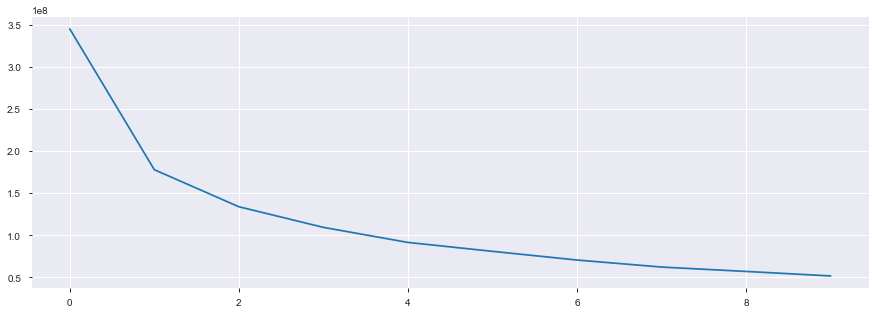

In [95]:
plt.figure(figsize=(15,5))
df.cluster_error.plot()
plt.show()

In [96]:
# It can be seen froom the curve that the inertia is is not increasing that rapidely after the 4 segments so we can take
# 4 or 5 segments for profiling the customers

In [97]:

km_3 = KMeans(n_clusters=3,random_state=123).fit(input_for_segmentation)
km_4 = KMeans(n_clusters=4,random_state=123).fit(input_for_segmentation)
km_5 = KMeans(n_clusters=5,random_state=123).fit(input_for_segmentation)
km_6 = KMeans(n_clusters=6,random_state=123).fit(input_for_segmentation)
km_7 = KMeans(n_clusters=7,random_state=123).fit(input_for_segmentation)
km_8 = KMeans(n_clusters=8,random_state=123).fit(input_for_segmentation)

## lets add thes to a dataframe to analyse them
profiling_df  = final_df.copy()

In [98]:
kmeans_df["cluster3"] = km_3.labels_
kmeans_df["cluster4"] = km_4.labels_
kmeans_df["cluster5"] = km_5.labels_
kmeans_df["cluster6"] = km_6.labels_
kmeans_df["cluster7"] = km_7.labels_
kmeans_df["cluster8"] = km_8.labels_

In [99]:
kmeans_df.cluster6.value_counts()

0    28805
3    10590
2     7095
1     3276
5     1853
4     1305
Name: cluster6, dtype: int64

### Profiling

In [100]:
profiling_output = pd.concat([kmeans_df.apply(np.mean).T,kmeans_df.groupby("cluster3").mean().T,kmeans_df.groupby("cluster4").mean().T,
kmeans_df.groupby("cluster5").mean().T,kmeans_df.groupby("cluster6").mean().T,kmeans_df.groupby("cluster7").mean().T,kmeans_df.groupby("cluster8").mean().T],axis=1)

In [101]:
size=pd.concat([pd.Series(kmeans_df.cluster3.size), pd.Series.sort_index(kmeans_df.cluster3.value_counts()), pd.Series.sort_index(kmeans_df.cluster4.value_counts()),
           pd.Series.sort_index(kmeans_df.cluster5.value_counts()), pd.Series.sort_index(kmeans_df.cluster6.value_counts()),
           pd.Series.sort_index(kmeans_df.cluster7.value_counts()), pd.Series.sort_index(kmeans_df.cluster8.value_counts())])

In [102]:
Seg_size=pd.DataFrame(size, columns=['Seg_size'])
Seg_Pct = pd.DataFrame(size/kmeans_df.cluster3.size, columns=['Seg_Pct'])

In [103]:
profiling_output_final=pd.concat([Seg_size.T, Seg_Pct.T, profiling_output], axis=0)

In [104]:
profiling_output_final.columns = ['Overall', 'KM3_1', 'KM3_2', 'KM3_3',
                                'KM4_1', 'KM4_2', 'KM4_3', 'KM4_4',
                                'KM5_1', 'KM5_2', 'KM5_3', 'KM5_4', 'KM5_5',
                                'KM6_1', 'KM6_2', 'KM6_3', 'KM6_4', 'KM6_5','KM6_6',
                                'KM7_1', 'KM7_2', 'KM7_3', 'KM7_4', 'KM7_5','KM7_6','KM7_7',
                                'KM8_1', 'KM8_2', 'KM8_3', 'KM8_4', 'KM8_5','KM8_6','KM8_7','KM8_8',]

In [105]:
profiling_output_final.to_csv("Summaries/profiling_output1.csv")

### Inference

We can use 6 segments of the customers
1. Label 1 and label 4 can be said to be premium customers the constitute 8% of the total customers and are good Quantity, Delivery_Charges, Average_Price and Invoice_Value. Actually their invoice value is way higher than the average invoice value. This implies that they are high revenue generating customers. If a person in this category has low retention then they can be enticed with advertisements. Label 4 Customes have very high Invoice_Value but they are also minimal in numbers only 2% of the customers

2. Here label 3 and label 5 Customers are good and similar in Average_Price and InvoiceValue and are bad performer in Delivery_Charges, Quantity and GST. They are 24% of the total number of customers. We can segment them as Gold customers because they are also the one that have higher Invoice_Value

3. label 2 customers are higher than average in quantity purchased and Delivery charges but have a average Invoice Value.

4. label 0 customers are the customers that can be called standard customers they are 54% of the total number of customers and are lower than average in Quantity, Average_Price and Invoice_Value


______

# Cross-Selling(Recommendation)

We will use Market Basket Analysis approach for Cross selling of products.

In [106]:
df_mba = final_df[["CustomerID","Product_Description","Quantity"]]

In [107]:
def check(x):
    if x>0:
        return 1
    else:
        return 0 
input_data = df_mba.pivot_table(columns = "Product_Description",index = "CustomerID",values="Quantity").fillna(0).applymap(check)

In [108]:
input_data.head()

Product_Description,1 oz Hand Sanitizer,20 oz Stainless Steel Insulated Tumbler,22 oz Android Bottle,22 oz YouTube Bottle Infuser,23 oz Wide Mouth Sport Bottle,24 oz YouTube Sergeant Stripe Bottle,25L Classic Rucksack,26 oz Double Wall Insulated Bottle,7&quot; Dog Frisbee,8 pc Android Sticker Sheet,...,YouTube Twill Cap,YouTube Women's Favorite Tee White,YouTube Women's Fleece Hoodie Black,YouTube Women's Racer Back Tank Black,YouTube Women's Short Sleeve Hero Tee Charcoal,YouTube Women's Short Sleeve Tri-blend Badge Tee Charcoal,YouTube Women's Short Sleeve Tri-blend Badge Tee Grey,YouTube Womens 3/4 Sleeve Baseball Raglan White/Black,YouTube Wool Heather Cap Heather/Black,YouTube Youth Short Sleeve Tee Red
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12347,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
12348,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
12350,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12356,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Model

In [109]:
frequent_itemset = apriori(input_data,use_colnames=True,min_support=0.07)

In [110]:
frequent_itemset.head()

,support,itemsets
0,0.076294,(1 oz Hand Sanitizer)
1,0.082425,(22 oz Android Bottle)
2,0.076975,(22 oz YouTube Bottle Infuser)
3,0.198910,(26 oz Double Wall Insulated Bottle)
4,0.153951,(8 pc Android Sticker Sheet)


## Rules

In [111]:
rules = association_rules(frequent_itemset,min_threshold=1,metric="lift")

In [112]:
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Nest Cam Indoor Security Camera - USA),(22 oz Android Bottle),0.649183,0.082425,0.074251,0.114376,1.387632,0.020742,1.036077
1,(22 oz Android Bottle),(Nest Cam Indoor Security Camera - USA),0.082425,0.649183,0.074251,0.900826,1.387632,0.020742,3.537409
2,(Nest Cam Outdoor Security Camera - USA),(22 oz Android Bottle),0.647139,0.082425,0.071526,0.110526,1.340931,0.018185,1.031593
3,(22 oz Android Bottle),(Nest Cam Outdoor Security Camera - USA),0.082425,0.647139,0.071526,0.867769,1.340931,0.018185,2.668512
4,(Nest Learning Thermostat 3rd Gen-USA - Stainl...,(22 oz Android Bottle),0.648501,0.082425,0.070163,0.108193,1.312626,0.016711,1.028894


In [113]:
# These are the items sets where there is a high to low confidence 
# Here confidence is the probability that the consequent is bought given that the antecedent is already bought
rules.sort_values(by='confidence', ascending=False )[:20]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
29123,(Nest Protect Smoke + CO White Wired Alarm-USA...,(Nest Cam Indoor Security Camera - USA),0.072888,0.649183,0.072888,1.0,1.540399,0.025570,inf
58518,(Nest Protect Smoke + CO White Battery Alarm-U...,(Nest Cam Indoor Security Camera - USA),0.076975,0.649183,0.076975,1.0,1.540399,0.027004,inf
58580,(Nest Protect Smoke + CO White Battery Alarm-U...,(Nest Cam Indoor Security Camera - USA),0.076294,0.649183,0.076294,1.0,1.540399,0.026765,inf
53434,(Nest Protect Smoke + CO White Battery Alarm-U...,(Nest Cam Indoor Security Camera - USA),0.073569,0.649183,0.073569,1.0,1.540399,0.025809,inf
52442,"(Google 22 oz Water Bottle, Nest Cam Outdoor S...",(Nest Cam Indoor Security Camera - USA),0.072888,0.649183,0.072888,1.0,1.540399,0.025570,inf
64594,(Nest Protect Smoke + CO White Battery Alarm-U...,(Nest Learning Thermostat 3rd Gen-USA - Stainl...,0.072207,0.648501,0.072207,1.0,1.542017,0.025381,inf
40614,(Nest Protect Smoke + CO White Wired Alarm-USA...,(Nest Learning Thermostat 3rd Gen-USA - Stainl...,0.076975,0.648501,0.076975,1.0,1.542017,0.027057,inf
10816,(Nest Protect Smoke + CO White Wired Alarm-USA...,(Nest Cam Indoor Security Camera - USA),0.077657,0.649183,0.077657,1.0,1.540399,0.027243,inf
41274,(Nest Protect Smoke + CO White Wired Alarm-USA...,(Nest Cam Indoor Security Camera - USA),0.089237,0.649183,0.089237,1.0,1.540399,0.031306,inf
33625,"(Google Laptop and Cell Phone Stickers, Google...",(Nest Learning Thermostat 3rd Gen-USA - Stainl...,0.080381,0.648501,0.080381,1.0,1.542017,0.028254,inf


In [114]:
# lets see the itemsets that have higher lift than 4 and they also have a high confidence 0f 0.8 or above
rules[ (rules['lift'] >= 4) &
       (rules['confidence'] >= 0.8) ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
21462,"(Nest Secure Alarm System Starter Pack - USA, ...","(Nest Thermostat E - USA, Nest Cam Indoor Secu...",0.085831,0.194142,0.070163,0.817460,4.210638,0.053500,4.414702
21855,"(Nest Secure Alarm System Starter Pack - USA, ...","(Nest Cam Outdoor Security Camera - USA, Nest ...",0.085831,0.185967,0.070845,0.825397,4.438398,0.054883,4.662187
22123,"(Nest Secure Alarm System Starter Pack - USA, ...","(Nest Thermostat E - USA, Nest Learning Thermo...",0.085831,0.201635,0.071526,0.833333,4.132883,0.054219,4.790191
23970,"(Nest Secure Alarm System Starter Pack - USA, ...",(Nest Learning Thermostat 3rd Gen-USA - Stainl...,0.108311,0.201635,0.088556,0.817610,4.054904,0.066717,4.377243
25353,(Nest Protect Smoke + CO White Wired Alarm-USA...,"(Nest Thermostat E - USA, Nest Cam Indoor Secu...",0.110354,0.194142,0.089237,0.808642,4.165216,0.067813,4.211260
...,...,...,...,...,...,...,...,...,...
67760,(Nest Protect Smoke + CO White Battery Alarm-U...,"(Nest Thermostat E - USA, Nest Cam Indoor Secu...",0.083787,0.194142,0.070163,0.837398,4.313336,0.053897,4.956029
67761,(Nest Protect Smoke + CO White Battery Alarm-U...,"(Nest Thermostat E - USA, Nest Learning Thermo...",0.083787,0.201635,0.070163,0.837398,4.153043,0.053269,4.909946
67763,(Nest Protect Smoke + CO White Battery Alarm-U...,"(Nest Cam Outdoor Security Camera - USA, Nest ...",0.085150,0.185967,0.070163,0.824000,4.430886,0.054328,4.625186
67782,(Nest Protect Smoke + CO White Battery Alarm-U...,"(Nest Thermostat E - USA, Nest Learning Thermo...",0.085831,0.177112,0.070163,0.817460,4.615507,0.054962,4.507997


_______

# Lifetime value of customers

In [115]:
sales_customer

,CustomerID,Gender,Location,Tenure_Months,Transaction_ID,Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Month,Coupon_Code,Discount_pct,GST,Invoice_Value,Week
0,12346,F,New York,31,38223,2019-09-15,GGOEAAAJ080816,Android Men's Engineer Short Sleeve Tee Charcoal,Apparel,1,19.99,75.00,Used,Sep,SALE30,0.3,0.18,91.51174,37
1,12346,F,New York,31,38223,2019-09-15,GGOEGOAR013099,Google Stylus Pen w/ LED Light,Office,2,5.50,75.00,Used,Sep,OFF30,0.3,0.10,83.47000,37
2,12347,M,New York,20,23979,2019-03-24,GGOEGOAQ020099,Four Color Retractable Pen,Office,1,2.99,14.41,Clicked,Mar,OFF30,0.3,0.10,17.69900,12
3,12347,M,New York,20,23979,2019-03-24,GGOEGOCT019199,Red Spiral Google Notebook,Office,1,9.99,14.41,Used,Mar,OFF30,0.3,0.10,22.10230,12
4,12347,M,New York,20,23980,2019-03-24,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,149.00,6.50,Used,Mar,ELEC30,0.3,0.10,121.23000,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52919,18283,F,New Jersey,36,40289,2019-10-10,GGOEGHPB071610,Google Twill Cap,Apparel,1,8.79,6.50,Used,Oct,SALE10,0.1,0.18,15.83498,41
52920,18283,F,New Jersey,36,40290,2019-10-10,GGOEAAEJ030916,Android Women's Long Sleeve Blended Cardigan Grey,Apparel,1,15.00,6.00,Used,Oct,SALE10,0.1,0.18,21.93000,41
52921,18283,F,New Jersey,36,40290,2019-10-10,GGOEGAEB027814,Google Women's Short Sleeve Hero Tee Black,Apparel,2,16.99,6.00,Used,Oct,SALE10,0.1,0.18,42.08676,41
52922,18283,F,New Jersey,36,40291,2019-10-10,GGOEGAAH034015,Google Men's Vintage Badge Tee Sage,Apparel,1,4.56,26.43,Clicked,Oct,SALE10,0.1,0.18,31.81080,41


In [116]:
df = sales_customer.copy()

In [117]:
df.groupby("CustomerID")["Invoice_Value"].sum().quantile([0.33,0.66])

0.33    1089.502190
0.66    3380.198748
Name: Invoice_Value, dtype: float64

In [118]:
def value(row):
    if row["Invoice_Value"]<=1089:
        row["Value"]="Low"
    elif (row["Invoice_Value"]>=1089) & (row["Invoice_Value"]<=3380):
        row["Value"] = "Medium"
    else:
        row["Value"] = "High"
    return row

In [119]:
df.groupby("CustomerID").sum().apply(value,axis=1)["Value"]

CustomerID
12346       Low
12347      High
12348    Medium
12350    Medium
12356    Medium
          ...  
18259       Low
18260    Medium
18269       Low
18277       Low
18283      High
Name: Value, Length: 1468, dtype: object

In [120]:
data = df.drop(["Transaction_ID","Avg_Price","Product_SKU","Product_Description","Product_Category","Month","Coupon_Code","Discount_pct"],axis=1)

In [121]:
data.head(2)

,CustomerID,Gender,Location,Tenure_Months,Date,Quantity,Delivery_Charges,Coupon_Status,GST,Invoice_Value,Week
0,12346,F,New York,31,2019-09-15,1,75.0,Used,0.18,91.51174,37
1,12346,F,New York,31,2019-09-15,2,75.0,Used,0.10,83.47000,37


In [122]:
data_final = data.groupby("CustomerID").agg({"Invoice_Value":np.mean,"Delivery_Charges":np.mean,"Quantity":np.mean,"Location":max,"Gender":max,"Coupon_Status":max,"Tenure_Months":max})

In [123]:
data_final["Value"] = df.groupby("CustomerID").sum().apply(value,axis=1)["Value"]

In [124]:
data_final.head()

,Invoice_Value,Delivery_Charges,Quantity,Location,Gender,Coupon_Status,Tenure_Months,Value
CustomerID,,,,,,,,
12346,87.490870,75.000000,1.500000,New York,F,Used,31,Low
12347,261.447399,11.085667,5.700000,New York,M,Used,20,High
12348,73.458954,8.571739,9.086957,California,M,Used,39,Medium
12350,86.319722,7.522353,1.235294,California,M,Used,25,Medium
12356,55.761917,17.708056,1.555556,Chicago,F,Used,31,Medium


In [125]:
data_final = pd.get_dummies(data_final,columns = ["Location","Gender","Coupon_Status"])

In [126]:
data_final.columns

Index(['Invoice_Value', 'Delivery_Charges', 'Quantity', 'Tenure_Months',
       'Value', 'Location_California', 'Location_Chicago',
       'Location_New Jersey', 'Location_New York', 'Location_Washington DC',
       'Gender_F', 'Gender_M', 'Coupon_Status_Clicked',
       'Coupon_Status_Not Used', 'Coupon_Status_Used'],
      dtype='object')

In [127]:
X = data_final[['Invoice_Value', 'Delivery_Charges', 'Quantity',
       'Location_California', 'Location_Chicago', 'Location_New Jersey',
       'Location_New York', 'Location_Washington DC', 'Gender_F', 'Gender_M',
       'Coupon_Status_Clicked', 'Coupon_Status_Not Used',
       'Coupon_Status_Used']]
Y = data_final["Value"]

In [128]:
from sklearn.model_selection import train_test_split

In [129]:
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=123)

In [130]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

log_reg = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
yhat = log_reg.predict(X_test)
print("Train set Accuracy: ", metrics.accuracy_score(y_train, log_reg.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))    

Train set Accuracy:  0.5391822827938672
Test set Accuracy:  0.4931972789115646


In [131]:
print(metrics.classification_report(y_test, yhat))   

              precision    recall  f1-score   support

        High       0.43      0.84      0.57        92
         Low       0.66      0.56      0.61       108
      Medium       0.29      0.07      0.12        94

    accuracy                           0.49       294
   macro avg       0.46      0.49      0.43       294
weighted avg       0.47      0.49      0.44       294



________

# Predicting Next Purchase

In [132]:
df = sales_customer.copy()

In [133]:
df["Date"] = pd.to_datetime(df.Date)
df["Month_Num"] = pd.to_datetime(df.Date).dt.month
df.groupby("CustomerID")["Date"].max()-df.groupby("CustomerID")["Date"].min()

CustomerID
12346     0 days
12347   223 days
12348   119 days
12350     0 days
12356     0 days
          ...   
18259     0 days
18260   105 days
18269    76 days
18277     0 days
18283    73 days
Name: Date, Length: 1468, dtype: timedelta64[ns]

In [135]:
data_final = df.groupby("CustomerID").agg({"Invoice_Value":np.mean,"Delivery_Charges":np.mean,"Quantity":np.mean,"Location":max,"Gender":max,"Coupon_Status":max,"Tenure_Months":max})

In [137]:
data_final["Days_Bw_Purchase"] = df.groupby("CustomerID")["Date"].max()-df.groupby("CustomerID")["Date"].min()

In [138]:
data_final["Quantity"] = data_final.Quantity.round()

In [11]:
data_final["Days_Bw_Purchase"] = df.groupby("CustomerID")["Transaction_Date"].max()-df.groupby("CustomerID")["Transaction_Date"].min()

In [140]:
data_final["Quantity"] = data_final.Quantity.round()

In [141]:
data_final.head()

,Invoice_Value,Delivery_Charges,Quantity,Location,Gender,Coupon_Status,Tenure_Months,Days_Bw_Purchase
CustomerID,,,,,,,,
12346,87.490870,75.000000,2.0,New York,F,Used,31,0 days
12347,261.447399,11.085667,6.0,New York,M,Used,20,223 days
12348,73.458954,8.571739,9.0,California,M,Used,39,119 days
12350,86.319722,7.522353,1.0,California,M,Used,25,0 days
12356,55.761917,17.708056,2.0,Chicago,F,Used,31,0 days


In [142]:
data_final["Days_Bw_Purchase"] = data_final.Days_Bw_Purchase.dt.days

In [144]:
def group(x):
    if x<31:
        return "0-30 Days"
    elif x>30 and x<61:
        return "30-60 Days"
    elif x>60 and x<91:
        return "60-90 Days"
    else:
        return "90+ Days"

In [145]:
data_final["Purchase_Category"] = data_final.Days_Bw_Purchase.apply(group)
data_final = pd.get_dummies(data_final,columns = ["Location","Gender","Coupon_Status"],drop_first=True)
data_final.head()


,Invoice_Value,Delivery_Charges,Quantity,Tenure_Months,Days_Bw_Purchase,Purchase_Category,Location_Chicago,Location_New Jersey,Location_New York,Location_Washington DC,Gender_M,Coupon_Status_Not Used,Coupon_Status_Used
CustomerID,,,,,,,,,,,,,
12346,87.490870,75.000000,2.0,31,0,0-30 Days,0,0,1,0,0,0,1
12347,261.447399,11.085667,6.0,20,223,90+ Days,0,0,1,0,1,0,1
12348,73.458954,8.571739,9.0,39,119,90+ Days,0,0,0,0,1,0,1
12350,86.319722,7.522353,1.0,25,0,0-30 Days,0,0,0,0,1,0,1
12356,55.761917,17.708056,2.0,31,0,0-30 Days,1,0,0,0,0,0,1


In [146]:
data_final.columns

Index(['Invoice_Value', 'Delivery_Charges', 'Quantity', 'Tenure_Months',
       'Days_Bw_Purchase', 'Purchase_Category', 'Location_Chicago',
       'Location_New Jersey', 'Location_New York', 'Location_Washington DC',
       'Gender_M', 'Coupon_Status_Not Used', 'Coupon_Status_Used'],
      dtype='object')

In [147]:
X = data_final.drop(["Purchase_Category","Days_Bw_Purchase"],axis=1)

In [148]:
Y = data_final.Purchase_Category

In [155]:
### Model
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=12345)
print("Shapes of train and test data",X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
log_reg = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,Y_train)
yhat = log_reg.predict(X_test)
print("********************************")
print("Train set Accuracy: ", metrics.accuracy_score(Y_train, log_reg.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(Y_test, yhat))   
print(metrics.classification_report(Y_test, yhat))  

Shapes of train and test data (1174, 11) (294, 11) (1174,) (294,)
********************************
Train set Accuracy:  0.626916524701874
Test set Accuracy:  0.6462585034013606
              precision    recall  f1-score   support

   0-30 Days       0.65      1.00      0.79       190
  30-60 Days       0.00      0.00      0.00        11
  60-90 Days       0.00      0.00      0.00        10
    90+ Days       0.00      0.00      0.00        83

    accuracy                           0.65       294
   macro avg       0.16      0.25      0.20       294
weighted avg       0.42      0.65      0.51       294



### Gradient boost classifier

In [157]:
from sklearn.ensemble import GradientBoostingClassifier

In [158]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0).fit(X_train, Y_train) 
yhat = clf.predict(X_test)

In [159]:
print(metrics.classification_report(Y_test, yhat))  

              precision    recall  f1-score   support

   0-30 Days       0.70      0.84      0.76       190
  30-60 Days       0.00      0.00      0.00        11
  60-90 Days       0.00      0.00      0.00        10
    90+ Days       0.47      0.35      0.40        83

    accuracy                           0.64       294
   macro avg       0.29      0.30      0.29       294
weighted avg       0.58      0.64      0.61       294



### Decision Tree


In [163]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [164]:
dtc = DecisionTreeClassifier()

params = {"criterion":np.array(["mse","gini"]),
                              "splitter":np.array(["best","random"]),
                              "max_depth":np.arange(1,13,1),
         "min_samples_split":np.arange(2,16,1)}

grid_tree = GridSearchCV(dtc,params,cv=5)

In [165]:
grid_tree.fit(X_train,Y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': array(['mse', 'gini'], dtype='<U4'),
                         'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
                         'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
                         'splitter': array(['best', 'random'], dtype='<U6')})

In [166]:
estimator = grid_tree.best_estimator_

In [167]:

grid_tree.best_score_

0.6269176213857065